In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from correlation_estimators import calculate_pearson
from sampling import pps, accept_reject
from scipy.stats.distributions import norm, expon

PROPERTY = 'fire_size'

dfo = pd.read_csv('./data/FW_Veg_Rem_Combined.csv')

cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]

def preprocess_missing_weather_data(df):
    df_subsample = df[df['Temp_pre_7'] == -1]
    df_clean = df[df['Temp_pre_7'] != -1]
    mean_weather_data = df_clean.groupby(['state', 'discovery_month'])[weather_columns].mean().reset_index()
    df_subsample.drop(weather_columns, axis=1, inplace=True)
    df_subsample = df_subsample.merge(mean_weather_data)
    df_clean = df_clean.append(df_subsample, ignore_index=True)
    return df_clean

df = preprocess_missing_weather_data(dfo)
df_full = df
df = pps(df, PROPERTY, 0.1)

df.stat_cause_descr.unique()


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array(['Debris Burning', 'Equipment Use', 'Miscellaneous', 'Arson',
       'Campfire', 'Lightning', 'Missing/Undefined', 'Fireworks',
       'Powerline', 'Children', 'Smoking', 'Railroad', 'Structure'],
      dtype=object)

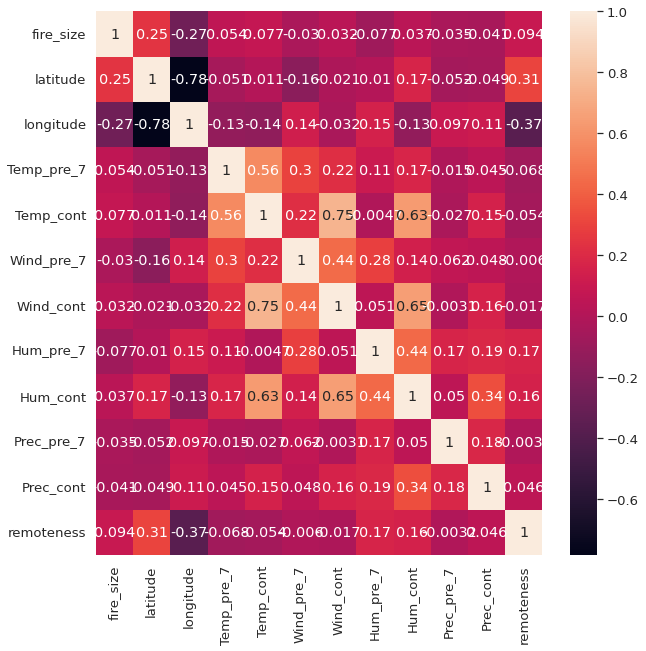

In [61]:
#correlation_matrix_min

to_drop = list(set(df.columns) - set(['fire_size', 'Temp_pre_7', 'Hum_pre_7', 'Wind_pre_7', 'Prec_pre_7', 'remoteness', 'latitude', 'longitude', 'Temp_cont', 'Hum_cont', 'Wind_cont', 'Prec_cont']))

df_min = df.drop(to_drop, axis=1)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df_min.corr(), annot = True, ax=ax)
plt.show()

In [62]:
#predictors_o = ['Temp_pre_7', 'Hum_pre_7', 'Wind_pre_7', 'Prec_pre_7', 'remoteness', 'latitude', 'longitude', 'Temp_cont', 'Hum_cont', 'Wind_cont', 'Prec_cont']

#predictors = ['remoteness', 'latitude', 'longitude']

#predictors += weather_columns

#for pred in predictors:
#    pr = calculate_pearson(df, pred, PROPERTY)
#    print(f'The Pearsons coefficient for {PROPERTY} and {pred} is {pr}')


#Based on that we take: remoteness, latitude, longitute, Temp_pre_7, Temp_pre_15, Temp_pre_30, Prec_pre_30, Hum_pre_7, Hum_pre_15, Hum_pre_30

In [63]:
#BAsesian network preparation

!git clone https://github.com/ITMO-NSS-team/BAMT.git
!pip install -r BAMT/requirements.txt

import os, sys

sys.path.append(os.path.join(os.path.dirname('./BAMT'), "BAMT"))

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

fatal: destination path 'BAMT' already exists and is not an empty directory.


In [64]:
bayesian_net_columns = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30', 'stat_cause_descr']
bayesian_net_columns_cont = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30']
to_drop = filter(lambda col: col != PROPERTY and not col in bayesian_net_columns, df.columns)

df_bayes = df.drop(to_drop, axis=1)
df_bayes['stat_cause_descr'] = df_bayes['stat_cause_descr'].apply(lambda x: str(x))

for col in bayesian_net_columns_cont:
    df_bayes[col] = df_bayes[col].apply(lambda x: float(x))

df_bayes.dropna(inplace=True)
df_bayes.reset_index(inplace=True, drop=True)
df_bayes.head(10)

,fire_size,stat_cause_descr,latitude,longitude,Temp_pre_30,Temp_pre_15,Temp_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,remoteness
0,30.18,Debris Burning,31.259000,-84.895600,20.079480,17.722714,18.188679,67.551783,61.733788,60.328571,0.0,0.162416
1,15.30,Equipment Use,36.586500,-96.323220,8.523263,5.933658,2.911842,76.615217,80.177291,85.369369,150.8,0.263943
2,5.00,Equipment Use,32.275940,-102.760900,6.224290,8.950698,8.880240,44.628895,32.515977,37.246939,0.0,0.327901
3,5.20,Miscellaneous,33.426303,-84.925226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.161130
4,1.00,Arson,40.746111,-75.748611,9.215850,9.625352,11.323707,66.972917,63.144681,65.285047,182.8,0.076025
5,10.00,Arson,33.370210,-98.447810,8.372812,7.059375,8.493939,61.569249,71.109474,78.982301,86.5,0.285984
6,3.80,Debris Burning,44.524631,-88.996043,0.578848,6.130116,7.645339,71.180254,68.552326,65.423729,40.2,0.192649
7,5.00,Debris Burning,31.560615,-96.291583,10.410706,13.517045,11.311230,63.708520,63.083721,56.908108,22.7,0.266943
8,10.00,Debris Burning,30.823796,-96.380568,28.834016,29.230492,29.885828,67.982322,65.747159,66.590818,0.0,0.268336
9,13.00,Debris Burning,34.080486,-83.861637,6.950617,0.000000,0.000000,58.975309,0.000000,0.000000,0.0,0.151147


In [65]:
nodes_type = get_nodes_type(df_bayes)
nodes_sign = get_nodes_sign(df_bayes)

nodes_type
nodes_sign

{'fire_size': 'pos',
 'latitude': 'pos',
 'longitude': 'neg',
 'Temp_pre_30': 'neg',
 'Temp_pre_15': 'neg',
 'Temp_pre_7': 'neg',
 'Hum_pre_30': 'pos',
 'Hum_pre_15': 'pos',
 'Hum_pre_7': 'pos',
 'Prec_pre_30': 'pos',
 'remoteness': 'pos'}

In [66]:
coded_data, coder = code_categories(df_bayes, 'label', ['stat_cause_descr'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', bayesian_net_columns_cont)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [67]:
bn_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
save_structure(bn_hc, 'struct_bnhc')
bn_hc_params = parameter_learning(discrete_data, nodes_type, bn_hc, 'simple')
save_params(bn_hc_params, 'params_bnhc')

draw_BN(bn_hc, nodes_type, 'bn_hc_draw')

bn_hc = read_structure('struct_bnhc')
bn_hc_params = read_params('params_bnhc')


bayes_hc = HyBayesianNetwork(bn_hc, bn_hc_params)

In [69]:
bn_evo_k2 = structure_learning(discrete_data, 'evo', nodes_type)
save_structure(bn_evo_k2, 'struct_evok2')
bn_evo_params = parameter_learning(discrete_data, nodes_type, bn_evo_k2, 'simple')
save_params(bn_evo_params, 'params_evok2')

draw_BN(bn_evo_k2, nodes_type, 'bn_evo_k2_drawing')

bn_evo_k2 = read_structure('struct_evok2')
bn_evo_params = read_params('params_evok2')

bayes_evok2 = HyBayesianNetwork(bn_evo_k2, bn_evo_params)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 11.799094385071413
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 1.1 min
Best metric is 11.799094385071413
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 2.2 min
Best metric is 11.513308877631633
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 3.1 min
Best metric is 11.513308877631633
Generation num: 3
max_depth: 6, no improvements: 1
spent time: 3.9 min
Best metric is 11.442508877631635
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 4.7 min
Best metric is 11.383908877631633
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 5.6 min
Best metric is 11.383908877631633
Generation num: 6
max_depth: 6, no improvements: 1
spent time: 6.5 min
Best metric is 11.383908877631633
Generation num: 7
max_depth: 6, no improvements: 2
spent time: 7.2 min
Best metric is 11.322808877631633
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 8.0 min
Best metric is 11.322808877631633
Generation num: 9
max

In [ ]:
bn_hc_mi = structure_learning(discrete_data, 'HC', nodes_type, 'MI')
save_structure(bn_hc_mi, 'struct_hcmi')
bn_hcmi_params = parameter_learning(discrete_data, nodes_type, bn_hc_mi, 'simple')
save_params(bn_hcmi_params, 'params_hcmi')

draw_BN(bn_hc_mi, nodes_type, 'bn_hc_mi_drawing')

bn_hc_mi = read_structure('struct_hcmi')
bn_hcmi_params = read_params('params_hcmi')

bayes_hcmi = HyBayesianNetwork(bn_hc_mi, bn_hcmi_params)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:238: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:224: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:236: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:182: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:156: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)


In [ ]:
df_val = accept_reject(dfo, PROPERTY, norm, 100)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/sampling.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  if r_m <= (prob_needed/prob_current):
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/sampling.py:46: RuntimeWarning: invalid value encountered in double_scalars
  if r_m <= (prob_needed/prob_current):


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
RMDS is {'fire_size': 29199.922}


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


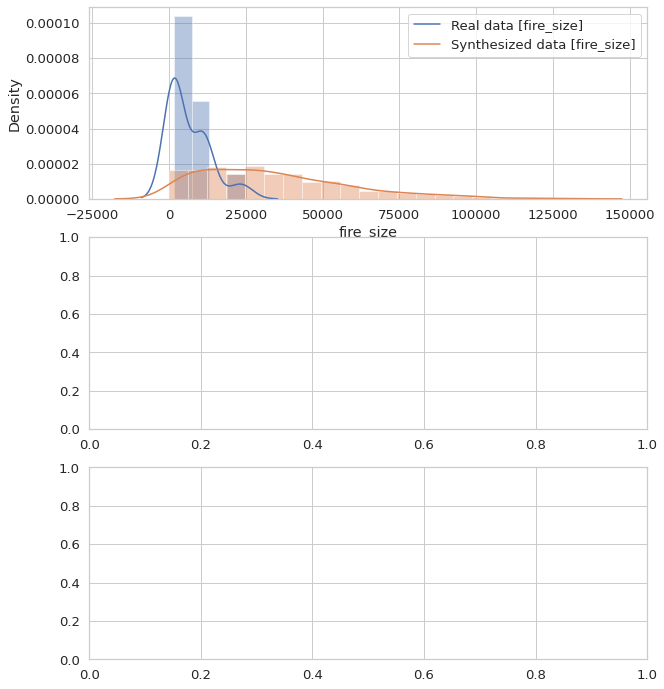

In [70]:
#stats and predictions

answ_hc =  calculate_acc(bayes_hc, df_val, ['fire_size'], 'simple')

synth_df_corr = generate_synthetics(bayes_hc, nodes_sign, 'simple', 1200)

print(f'RMDS is {answ_hc[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(df_val['fire_size'], ax=ax[0])
sns.distplot(synth_df_corr['fire_size'], ax=ax[0])
ax[0].legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()

In [75]:
answ_hcmi =  calculate_acc(bayes_hcmi, df_bayes, ['fire_size'], 'simple')

synth_df_corr = generate_synthetics(bayes_hcmi, nodes_sign, 'simple', 1200)

print(f'RMDS is {answ_hcmi[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(df_val['fire_size'], ax=ax[0])
sns.distplot(synth_df_corr['fire_size'], ax=ax[0])
ax[0].legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()

0
"['Debris Burning']"
1
"['Equipment Use']"
2
"['Equipment Use']"
3
"['Miscellaneous']"
4
"['Arson']"
5
"['Arson']"
6
"['Debris Burning']"
7
"['Debris Burning']"
8
"['Debris Burning']"
9
"['Debris Burning']"
10
"['Equipment Use']"
11
"['Arson']"
12
"['Debris Burning']"
13
"['Debris Burning']"
14
"['Arson']"
15
"['Debris Burning']"
16
"['Arson']"
17
"['Equipment Use']"
18
"['Campfire']"
19
"['Debris Burning']"
20
"['Debris Burning']"
21
"['Lightning']"
22
"['Arson']"
23
"['Missing/Undefined']"
24
"['Arson']"
25
"['Missing/Undefined']"
26
"['Debris Burning']"
27
"['Lightning']"
28
"['Missing/Undefined']"
29
"['Lightning']"
30
"['Miscellaneous']"
31
"['Miscellaneous']"
32
"['Debris Burning']"
33
"['Debris Burning']"
34
"['Missing/Undefined']"
35
"['Fireworks']"
36
"['Missing/Undefined']"
37
"['Debris Burning']"
38
"['Equipment Use']"
39
"['Miscellaneous']"
40
"['Debris Burning']"
41
"['Debris Burning']"
42
"['Powerline']"
43
"['Debris Burning']"
44
"['Arson']"
45
"['Arson']"
46
"['Debris

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
RMDS is {'fire_size': 37584.207}


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


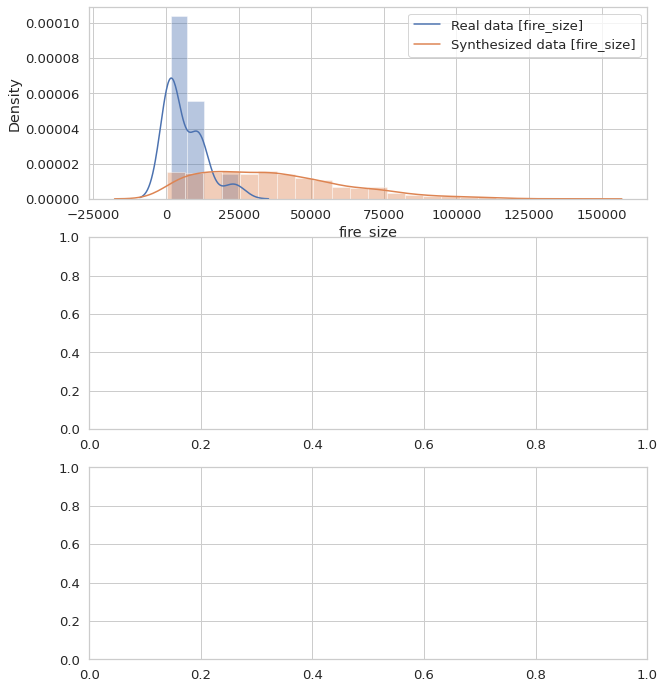

In [73]:

answ_evok2 =  calculate_acc(bayes_evok2, df_val, ['fire_size'], 'simple')

synth_df_corr = generate_synthetics(bayes_evok2, nodes_sign, 'simple', 1200)

print(f'RMDS is {answ_evok2[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(df_val['fire_size'], ax=ax[0])
sns.distplot(synth_df_corr['fire_size'], ax=ax[0])
ax[0].legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()